## Profile Likelihoods
The [profile likelihood](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btp358) method is a means of assessing a models identifiability status. PyCoTools and COPASI can together be used to efficiently configure a profile likelihood analysis of a model using either the current model parameters or parameters from a parameter estimation that have been written to file. 

.. important:: 
   The parameter estimation task is assumed to already be configured prior to running the profile likelihood.

### Build a model for demonstration

In [ ]:
import os
from pycotools import tasks, model, viz, utils
import seaborn
import matplotlib
import pandas
%matplotlib inline
seaborn.set_style('white')
seaborn.set_context('notebook')


In [2]:
antimony_string = """
model MM()
  k1 = 2
  k2 = 4
  k3 = 6
  
  E = 10
  S = 1000
  P=0
  
  SBindE: S + E => SE; k1*S*E
  SUnbindE: SE => S + E; k2*SE
  Conversion: SE => E + P; k3*SE
end
"""

directory = r'/home/b3053674/Documents/Models/2018/07_July'

model_file = os.path.join(directory, 'profile_likelihood_model.cps')

with model.BuildAntimony(model_file) as loader:
    mod = loader.load(antimony_string)
    
mod

Model(name=MM, time_unit=s, volume_unit=l, quantity_unit=mol)

### Simulate some data

In [3]:
report_loc = os.path.join(directory, 'synth_data.csv')
tc = tasks.TimeCourse(mod, end=20, intervals=10, step_size=2,
                      report_name=report_loc,
                      metabolites=['S', 'P'],
                      global_quantities=[])

## format time series data for compatibility with pycotools parameter estimation 
utils.format_timecourse_data(tc.report_name)

,Time,S,P
0,0,1.000000e+03,0.000
1,2,8.588050e+02,131.259
2,4,7.276450e+02,262.430
3,6,5.966540e+02,393.438
4,8,4.659160e+02,524.201
5,10,3.356010e+02,654.560
6,12,2.061380e+02,784.123
7,14,7.930950e+01,911.340
8,16,1.851430e-01,1000.100
9,18,1.032290e-05,1001.000


### Fit the data back to the model
Do not estimate metabolites. Limit the estimation to between 1 and 10 so the estimates will be good. Repeat the estimation 10 times

In [4]:
MPE = tasks.MultiParameterEstimation(
    mod, tc.report_name, upper_bound=10,
    lower_bound=1, method='hooke_jeeves',
    run_mode=True, metabolites=[], iteration_limit=500,
    pe_number=10
    )
MPE.write_config_file()
MPE.setup()
MPE.run()

viz.Parse(MPE).data

pycotools.tasks:INFO:3748:    running model: 0


,k1,k2,k3,RSS
0,2.04130,4.17350,5.99978,0.000301
1,2.35601,5.68654,5.99945,0.003649
2,1.67421,2.41428,6.00035,0.006037
3,2.58370,6.82563,5.99950,0.007181
4,2.86622,8.21383,5.99943,0.012828
5,2.98754,8.81198,5.99940,0.015362
6,3.09629,9.31470,5.99925,0.017560
7,3.00296,8.74665,5.99881,0.017874
8,3.22633,9.96450,5.99927,0.020209
9,3.21867,9.99569,5.99956,0.020881


### Calculate Profile Likelihoods Using the Estimation Data
If PyCoTools has been used to configure the parameter estimation, then there will be a file or list of files containing the parameter estimation data. Parameter sets can be extracted from these files and used in profile likelihood calculations. In this situation the profile likelihood configuration process is largely automatic. 

The `ProfileLikelihood` class requires the `model.Model` object as first argument. The model must already be configured with the parameter estimation that produced the data. This is automatically performed with `tasks.MultiParameterEstimation` if it was used for configuration. 

.. important:: Make sure you use the same model that produced the parameter estimation data. It is easy to get mixed up. 

The `ProfileLikelihood` object can take a pandas dataframe as argument to the `df` keyword which is the same as the output from `viz.Parse(MPE).data`. This can be used for manually specifying parameter values for profile likelihood calculations. Alternatively and more commonly used is the `parameter_path` argument which is the full path to the directory containing a list of parameter estimation files. For convenience, here we use `MPE.results_directory` which is where the data is stored. Also, the `index` argument requires an integer and is the index of best fitting parameter set that you would like to calculate profile likelihoods from. An `index=0` specifies the parameter set that has the lowest `RSS` value. PyCoTools will insert this parameter set into the model before computing profile likelihoods.

.. note:: The `index` argument also excepts a list of integers for configuring profile likelihoods around multiple sets of parameters at the same time. 

In [11]:
pl = tasks.ProfileLikelihood(mod, parameter_path=MPE.results_directory, index=0, run=True, 
                            intervals=20)

pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k3.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k2.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k1.cps


.. WARNING:: For other tasks, the `run_mode` kwarg is used to tell PyCoTools how to run the model. In the `ProfileLikelihood` class, the `run` argument performs the same function. This is due to be updated in the next version, but for now, just be aware of the difference. 

### Plot Profile Likelihoods

('idx', 0)


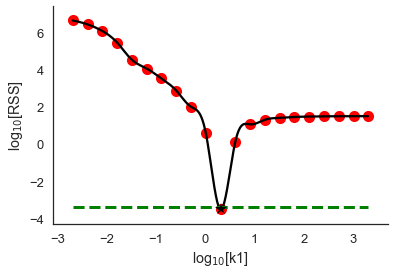

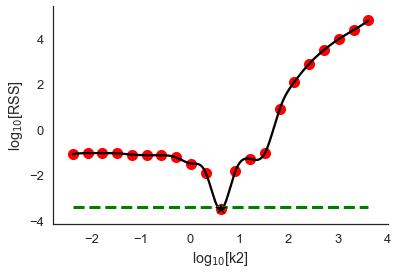

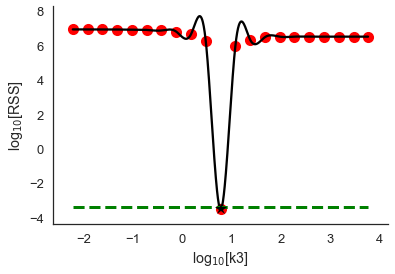

In [12]:
viz.PlotProfileLikelihood(pl, interpolation='cubic')

### Profile likelihoods around current parameters
PyCoTools is not as flexible as COPASI in the types of parameter estimation you can configure. For instance, no support is yet built for the `Affected Experiments` section (as described in caveats). Therefore it is sometimes desirable to calculate profile likelihoods from the current parameters. However, in this case, not everything can be automated and so there are a few additional things you need to do. 

Firstly, make sure the model is configured exactly as it was for the parameter estimation. If the current parameter estimation configuration does reflect that which was used to estimate the model parameters then you'll get incorrect results. 

Secondly, ensure you have noted the best RSS value as it will be needed for calculation of the confidence level. The other metric needed is the number of data points used for estimation, however, PyCoTools uses the experiment configuration to find these data files and count the data points. 

To demonstrate we'll still use the above example but we'll first insert the 5th best parameter set before running the profile likelihood. As we have modified the parameter estimation task in the previous example, we will reconfigure the parameter estimation using the `MultiParameterEstimation` (but note this bit will be done manually in a real problem). 

.. note:: The following code is copied from above. The only difference is that we have not run the parameter estimation, only used `MultiParameterEstimation` for task configuration. 

In [15]:
MPE = tasks.MultiParameterEstimation(
    mod, tc.report_name, upper_bound=10,
    lower_bound=1, method='hooke_jeeves',
    run_mode=False, metabolites=[], iteration_limit=500,
    pe_number=10
    )
MPE.write_config_file()
MPE.setup()

{0: Model(name=MM, time_unit=s, volume_unit=l, quantity_unit=mol)}

#### Collect the best RSS value
In a real profile likelihood calculation, you'll have already ran the parameter estimation using the COPASI UI and noted the best RSS value for later. Here, we'll look at the data estimated earlier. 

In [14]:
df = viz.Parse(MPE).data
df

,k1,k2,k3,RSS
0,2.04130,4.17350,5.99978,0.000301
1,2.35601,5.68654,5.99945,0.003649
2,1.67421,2.41428,6.00035,0.006037
3,2.58370,6.82563,5.99950,0.007181
4,2.86622,8.21383,5.99943,0.012828
5,2.98754,8.81198,5.99940,0.015362
6,3.09629,9.31470,5.99925,0.017560
7,3.00296,8.74665,5.99881,0.017874
8,3.22633,9.96450,5.99927,0.020209
9,3.21867,9.99569,5.99956,0.020881


#### Insert the parameter values
Again, when doing this in real scenario, you'll already have estimated the parameters and updated the model. Here, we'll insert the 5th best parameter set using `model.InsertParameters` instead. Use `model.open()` to verify the correct parameters have been inserted. 

In [9]:
mod.insert_parameters(df=df, index=5, inplace=True)

#### Calculate Profile Likelihoods

In [10]:
pl = tasks.ProfileLikelihood(mod, index='current_parameters', run='parallel', intervals=20)

pycotools.tasks:WARNING:4457:    Parameter estimation data has been specified without an index so will be ignored. Specify argument to index kwarg
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k3.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k2.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k1.cps


('idx', 0)


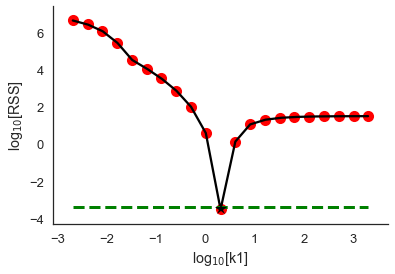

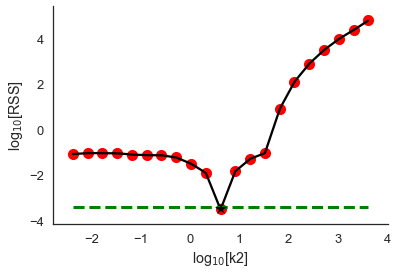

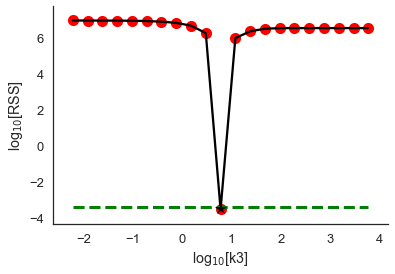

In [19]:
viz.PlotProfileLikelihood(pl, interpolation='linear')

### Multiple Profile Likelihoods
It is also possible to compute profile likelihoods from multiple points in parameter space. 

In [21]:
pl = tasks.ProfileLikelihood(mod, parameter_path=MPE.results_directory, index=[0, 3, 5, 7], run=True, 
                            intervals=10)

pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k3.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k2.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/0/k1.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/3/k3.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/3/k2.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/3/k1.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/5/k3.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/5/k2.cps
pycotools.tasks:INFO:4942:    running /home/b3053674/Documents/Models/2018/07_July/ProfileLikelihoods/5/k1.cps
p

#### Plotting
To plot all on the same graph, use the index and multiple arguments like in the following. 

.. note:: when saving multiplot profile likelihoods to file, the algorithm starts at the highest index, plots the data and then works its way to the lowest. Therefore the lowest index contains graphs you want. 

('idx', 0)
('idx', 3)
('idx', 5)
('idx', 7)


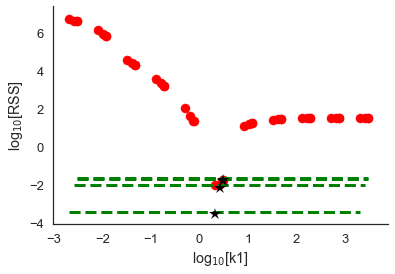

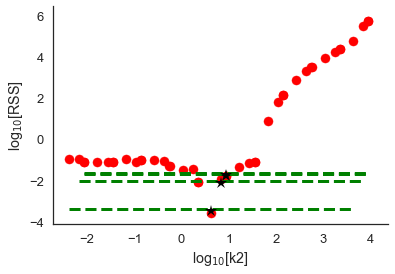

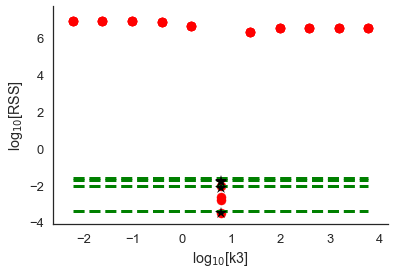

In [24]:
viz.PlotProfileLikelihood(pl, index=[0, 3, 5, 7], multiplot=True)